In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/optiver-trading-at-the-close/public_timeseries_testing_util.py
/kaggle/input/optiver-trading-at-the-close/train.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/sample_submission.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/revealed_targets.csv
/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv
/kaggle/input/optiver-trading-at-the-close/optiver2023/competition.cpython-310-x86_64-linux-gnu.so
/kaggle/input/optiver-trading-at-the-close/optiver2023/__init__.py


In [2]:
# Viz libraries
import seaborn as sns
import matplotlib.pyplot as plt

# For training and evaluation
from sklearn.model_selection import GridSearchCV, train_test_split  
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor 
import tensorflow as tf
import tensorflow_estimator as tf_estimator
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
path_train = "/kaggle/input/optiver-trading-at-the-close/train.csv"
path_test = "/kaggle/input/optiver-trading-at-the-close/example_test_files/test.csv"
pd.options.display.float_format = '{:.2f}'.format

In [4]:
df0 = pd.read_csv(path_train)

In [5]:
df = df0.copy()

# First look

In [6]:
df.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,1.00,13380276.64,NaN,NaN,1.00,60651.50,1.00,8493.03,1.00,-3.03,0,0_0_0
1,1,0,0,166603.91,-1,1.00,1642214.25,NaN,NaN,1.00,3233.04,1.00,20605.09,1.00,-5.52,0,0_0_1
2,2,0,0,302879.87,-1,1.00,1819368.03,NaN,NaN,1.00,37956.00,1.00,18995.00,1.00,-8.39,0,0_0_2
3,3,0,0,11917682.27,-1,1.00,18389745.62,NaN,NaN,1.00,2324.90,1.00,479032.40,1.00,-4.01,0,0_0_3
4,4,0,0,447549.96,-1,1.00,17860614.95,NaN,NaN,1.00,16485.54,1.00,434.10,1.00,-7.35,0,0_0_4


In [7]:
df.dtypes

stock_id                     int64
date_id                      int64
seconds_in_bucket            int64
imbalance_size             float64
imbalance_buy_sell_flag      int64
reference_price            float64
matched_size               float64
far_price                  float64
near_price                 float64
bid_price                  float64
bid_size                   float64
ask_price                  float64
ask_size                   float64
wap                        float64
target                     float64
time_id                      int64
row_id                      object
dtype: object

In [8]:
df.describe()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id
count,5237980.00,5237980.00,5237980.00,5237760.00,5237980.00,5237760.00,5237760.00,2343638.00,2380800.00,5237760.00,5237980.00,5237760.00,5237980.00,5237760.00,5237892.00,5237980.00
mean,99.29,241.51,270.00,5715293.10,-0.01,1.00,45100245.28,1.00,1.00,1.00,51813.59,1.00,53575.68,1.00,-0.05,13310.05
std,57.87,138.53,158.75,20515906.30,0.89,0.00,139841291.28,0.72,0.01,0.00,111421.41,0.00,129355.44,0.00,9.45,7619.27
min,0.00,0.00,0.00,0.00,-1.00,0.94,4316.61,0.00,0.79,0.93,0.00,0.94,0.00,0.94,-385.29,0.00
25%,49.00,122.00,130.00,84534.15,-1.00,1.00,5279575.17,1.00,1.00,1.00,7374.72,1.00,7823.70,1.00,-4.56,6729.00
50%,99.00,242.00,270.00,1113604.44,0.00,1.00,12882638.56,1.00,1.00,1.00,21969.00,1.00,23017.92,1.00,-0.06,13345.00
75%,149.00,361.00,410.00,4190951.00,1.00,1.00,32700130.58,1.00,1.00,1.00,55831.68,1.00,57878.41,1.00,4.41,19907.00
max,199.00,480.00,540.00,2982027811.68,1.00,1.08,7713682054.05,437.95,1.31,1.08,30287840.00,1.08,54405000.00,1.08,446.07,26454.00


In [9]:
df.isna().sum()

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 220
imbalance_buy_sell_flag          0
reference_price                220
matched_size                   220
far_price                  2894342
near_price                 2857180
bid_price                      220
bid_size                         0
ask_price                      220
ask_size                         0
wap                            220
target                          88
time_id                          0
row_id                           0
dtype: int64

In [10]:
df.dropna(subset=["imbalance_size", "reference_price","matched_size","ask_price","wap","target"], inplace=True)

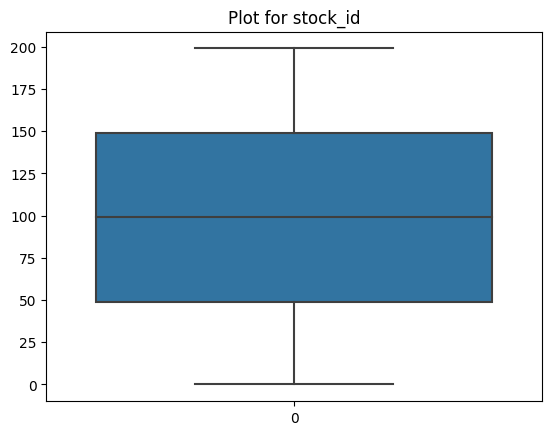

-----------------------------------------------------------------------------


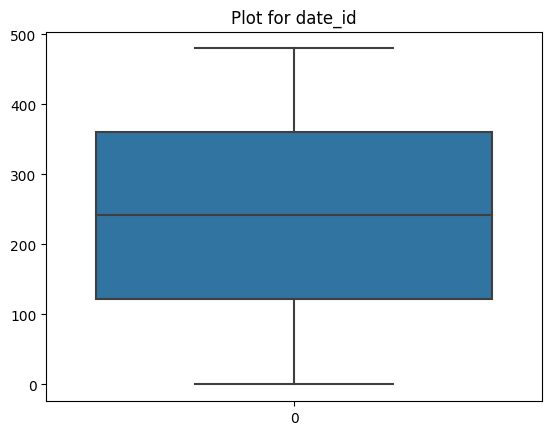

-----------------------------------------------------------------------------


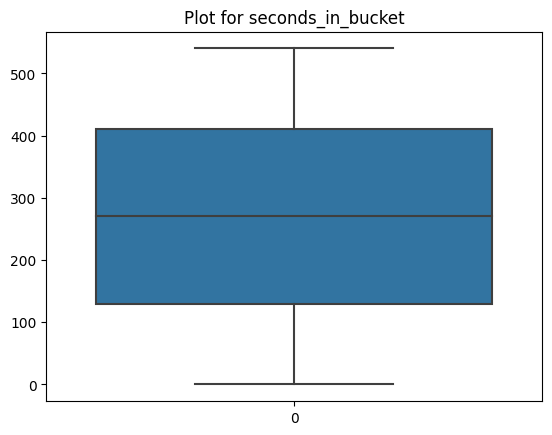

-----------------------------------------------------------------------------


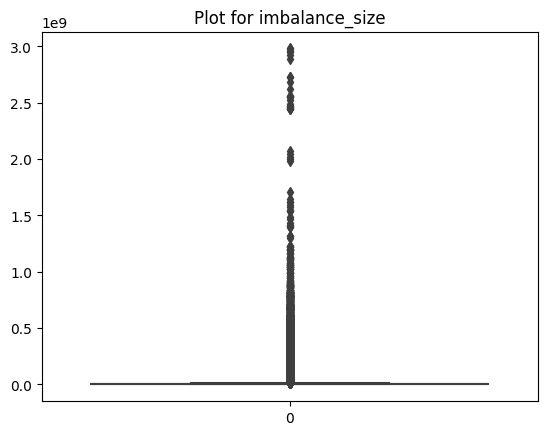

-----------------------------------------------------------------------------


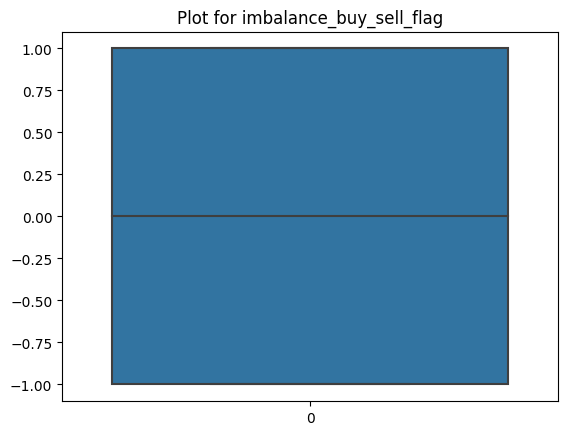

-----------------------------------------------------------------------------


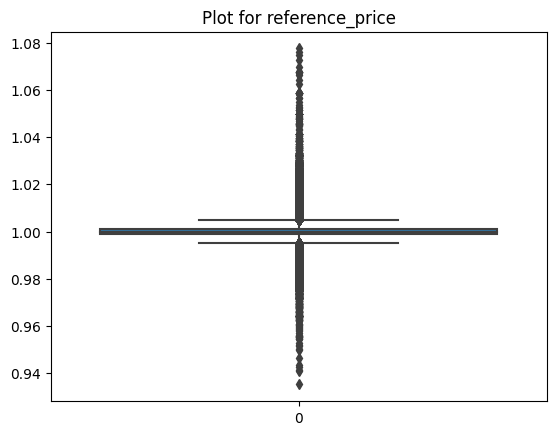

-----------------------------------------------------------------------------


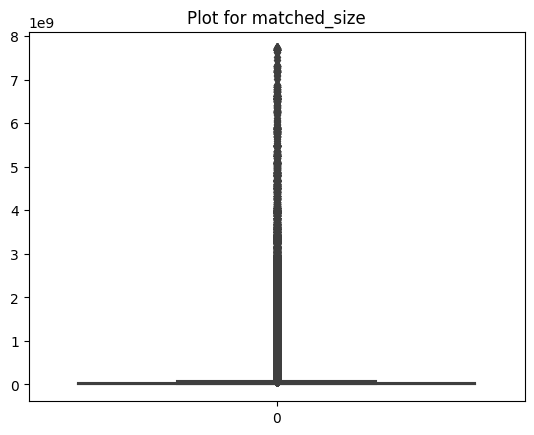

-----------------------------------------------------------------------------


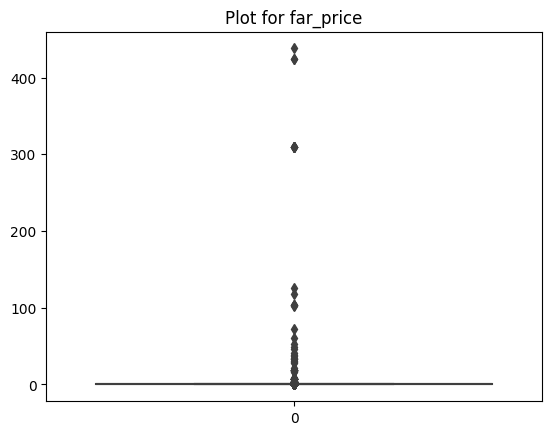

-----------------------------------------------------------------------------


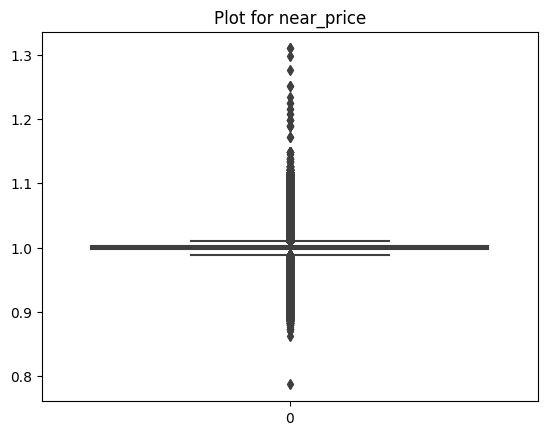

-----------------------------------------------------------------------------


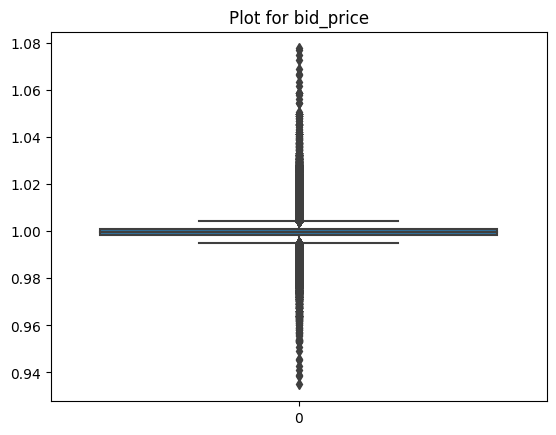

-----------------------------------------------------------------------------


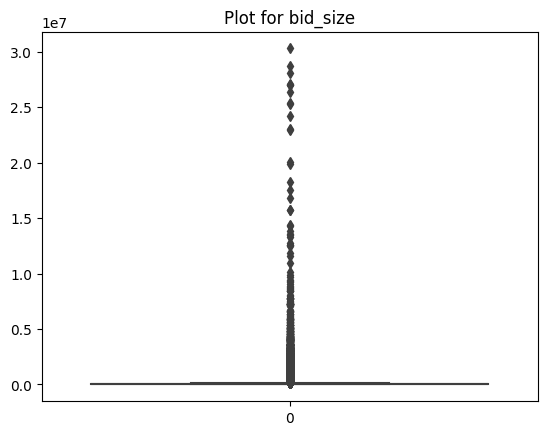

-----------------------------------------------------------------------------


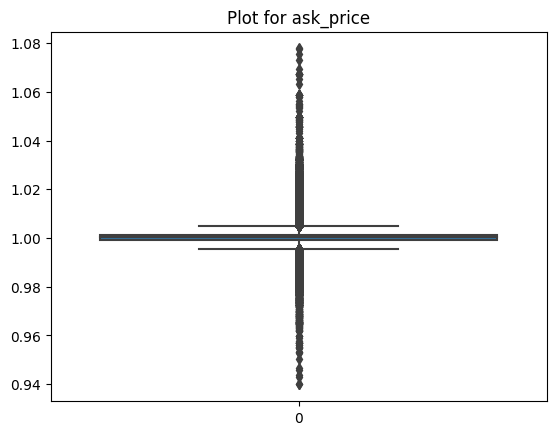

-----------------------------------------------------------------------------


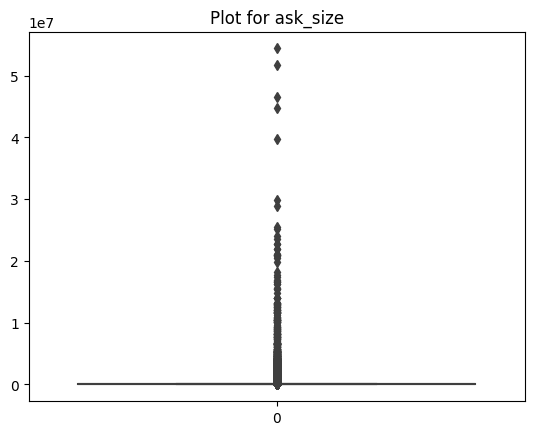

-----------------------------------------------------------------------------


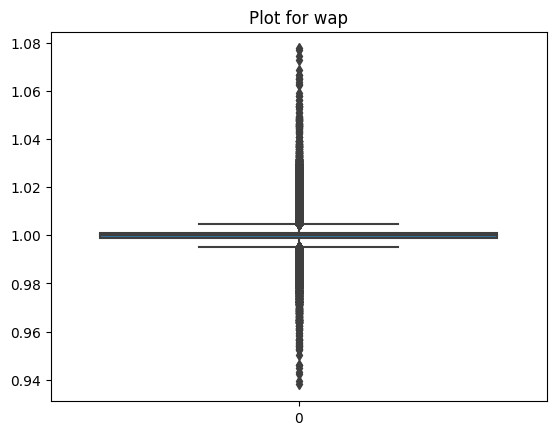

-----------------------------------------------------------------------------


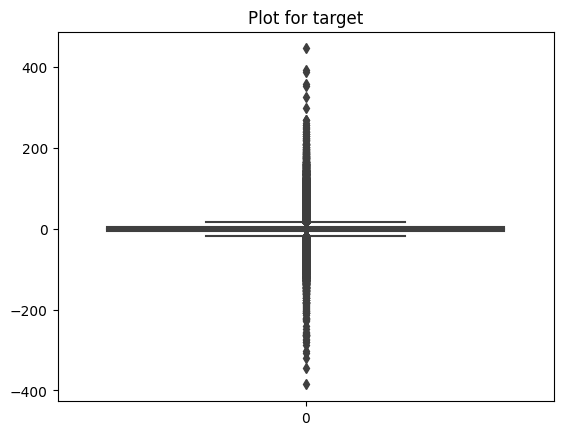

-----------------------------------------------------------------------------


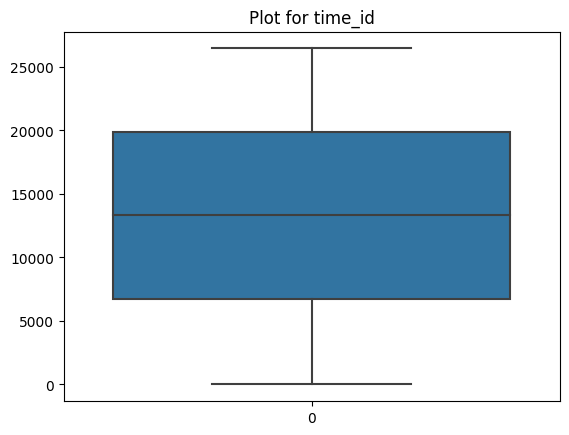

-----------------------------------------------------------------------------


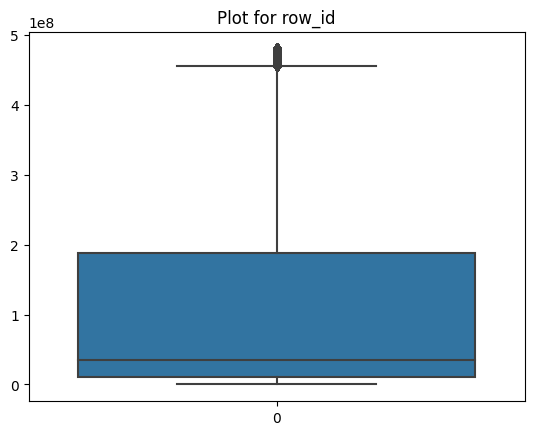

-----------------------------------------------------------------------------


In [11]:
for col in df.columns:
    sns.boxplot(df[col])
    plt.title(f"Plot for {col}")
    plt.show()
    print("-----------------------------------------------------------------------------")

In [12]:
df["stock_id"] = df["stock_id"].astype("object")
df["time_id"] = df["time_id"].astype("object")
df["date_id"] = df["date_id"].astype("object")

In [13]:
#df_prep = pd.get_dummies(df[:round(len(df)/5)])

In [14]:
#df_prep.columns

# Model Building

## Split the data

In [15]:
df.columns

Index(['stock_id', 'date_id', 'seconds_in_bucket', 'imbalance_size',
       'imbalance_buy_sell_flag', 'reference_price', 'matched_size',
       'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price',
       'ask_size', 'wap', 'target', 'time_id', 'row_id'],
      dtype='object')

In [16]:
X = df.drop(columns=["row_id", "stock_id", "date_id", "time_id", "far_price", "near_price"])
y = df["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [17]:
model = RandomForestRegressor(random_state=42)

In [18]:

%%time
model.fit(X_train, y_train)

CPU times: user 1h 12min 1s, sys: 1.17 s, total: 1h 12min 2s
Wall time: 1h 12min 2s


RandomForestRegressor(random_state=42)

In [20]:
with open("randomRegressorModel.pkl", "wb") as file:
    pickle.dump(model, file)

In [ ]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print("Mean Squared Error:", mse)
print("R-squared (R2) Score:", r2)

In [ ]:
with open("randomRegressorModel.pkl", "rb") as file:
    model = pickle.load(model)

# API of Time ID--------------------------------------------------------

In [9]:
input_paths = [path_train, path_test]
group_id_column = "time_id"


In [19]:
'''
An unlocked version of the timeseries API intended for testing alternate inputs.
Mirrors the production timeseries API in the crucial respects, but won't be as fast.

ONLY works afer the first three variables in MockAPI.__init__ are populated.
'''

from typing import Sequence, Tuple

import pandas as pd


class MockApi:
    def __init__(self):
        '''
        YOU MUST UPDATE THE FIRST THREE LINES of this method.
        They've been intentionally left in an invalid state.

        Variables to set:
            input_paths: a list of two or more paths to the csv files to be served
            group_id_column: the column that identifies which groups of rows the API should serve.
                A call to iter_test serves all rows of all dataframes with the current group ID value.
            export_group_id_column: if true, the dataframes iter_test serves will include the group_id_column values.
        '''
        self.input_paths: Sequence[str] = input_paths
        self.group_id_column: str = group_id_column
        self.export_group_id_column: bool = True
        # iter_test is only designed to support at least two dataframes, such as test and sample_submission
        assert len(self.input_paths) >= 2

        self._status = 'initialized'
        self.predictions = []

    def iter_test(self) -> Tuple[pd.DataFrame]:
        '''
        Loads all of the dataframes specified in self.input_paths,
        then yields all rows in those dataframes that equal the current self.group_id_column value.
        '''
        if self._status != 'initialized':

            raise Exception('WARNING: the real API can only iterate over `iter_test()` once.')

        dataframes = []
        for pth in self.input_paths:
            dataframes.append(pd.read_csv(pth, low_memory=False))
        group_order = dataframes[0][self.group_id_column].drop_duplicates().tolist()
        dataframes = [df.set_index(self.group_id_column) for df in dataframes]

        for group_id in group_order:
            self._status = 'prediction_needed'
            current_data = []
            for df in dataframes:
                cur_df = df.loc[group_id].copy()
                # returning single line dataframes from df.loc requires special handling
                if not isinstance(cur_df, pd.DataFrame):
                    cur_df = pd.DataFrame({a: b for a, b in zip(cur_df.index.values, cur_df.values)}, index=[group_id])
                    cur_df.index.name = self.group_id_column
                cur_df = cur_df.reset_index(drop=not(self.export_group_id_column))
                current_data.append(cur_df)
            yield tuple(current_data)

            while self._status != 'prediction_received':
                print('You must call `predict()` successfully before you can continue with `iter_test()`', flush=True)
                yield None

        with open('submission.csv', 'w') as f_open:
            pd.concat(self.predictions).to_csv(f_open, index=False)
        self._status = 'finished'

    def predict(self, user_predictions: pd.DataFrame):
        '''
        Accepts and stores the user's predictions and unlocks iter_test once that is done
        '''
        if self._status == 'finished':
            raise Exception('You have already made predictions for the full test set.')
        if self._status != 'prediction_needed':
            raise Exception('You must get the next test sample from `iter_test()` first.')
        if not isinstance(user_predictions, pd.DataFrame):
            raise Exception('You must provide a DataFrame.')

        self.predictions.append(user_predictions)
        self._status = 'prediction_received'


def make_env():
    return MockApi()

In [15]:
mock_api = make_env()

In [14]:
df0.iter_test()

AttributeError: 'DataFrame' object has no attribute 'iter_test'

In [20]:
for dataframes_tuple in mock_api.iter_test():
    # Perform operations on the data
    if dataframes_tuple:
        data_from_test, data_from_submission = dataframes_tuple
        # Your processing logic here
        print(data_from_test)
        print(data_from_submission)
        print("Next Iteration")
        # You can access the dataframes in dataframes_tuple
        # Example: data_from_test, data_from_submission


Exception: WARNING: the real API can only iterate over `iter_test()` once.